## Mean Reversion Strategies

**Context:** Using this notebook to experiment and prototype mean-reversion hypothesis tests as well as strategies. Strategies to explore include:

- Single asset mean reversion strategies (rangebound markets)
- Pairs trading strategies
- Basket trading

_Author: Matthew Garton_  
_Garton Research & Trading, 2021_

In [1]:
# standard datasci imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# packages for working with financial data
import mplfinance
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.foreignexchange import ForeignExchange
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances

%matplotlib inline

### Helper Functions: Statistical Tests for Mean Reversion

In [2]:
# import statistical packages
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pykalman import KalmanFilter
from hurst import compute_Hc
from arch.unitroot import VarianceRatio

# generated from scratch
def generate_hurst_exponent(ts):
    """
    Return the Hurst exponent of a time series. Adapted from 
    code snippet found in QuantStart article, 'Basics of Statisticsl
    Mean Reversion Testing' found here
    https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing/
    
    :param ts: numpy array of time series values
    :return h: Hurst exponent
    """

    # initiate range of lagged values
    lags = range(2, 20)

    # calculate the array of variances of lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # estimate the Hurst exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    
    # return the Hurst exponent
    return poly[0]*2


def variance_ratio(ts, tau=2):
    """
    Calculate the Variance Ratio test statistic for a time series
    Source: Lo, 2001
    
    :param ts: numpy array of time series values
    :param tau: arbitrary time lag for which to perform test
    :return vratio: test statistic for variance ratio test 
    """

    # TODO: verify and optimize calculation
    # calculate variance of diffs
    vardiff = np.var([np.subtract(ts[t], ts[t-tau]) for t in ts[:-tau]])

    # calculate test statistic
    return vardiff/(tau * vardiff)


def mean_reversion_half_life(ts):
    """
    Compute the half-life of mean reversion for a time series

    :param ts: numpy array of time series values
    :return lambda: the half-life (in periods) of mean reversion for the time series
    
    """

    # generate array of lagged-values
    ylag = np.roll(ts, 1)[1:]
    print(ts)
    print(ylag)
    
    # generate array of first-differences
    dY = np.diff(ts)
    
    # regress diffs on lagged values
    lr = LinearRegression()
    lr.fit(ylag, dY)

    # calculate half-life
    return -np.log(2)/lr.coef_

### Read in Data from Alpha Vantage

Refer to Alpha Vantage documentation [here](https://www.alphavantage.co/documentation/)

In [3]:
from utils.data_ingestion import get_stock_prices, get_forex_prices

In [11]:
# TODO: implement data gathering
usd_cad = get_forex_prices(
    base='CAD',
    price='USD',
    source='av'
)

# Small sample of data - replicating Ernest Chan's example in Algorithmic Trading for testing purposes
# TODO: replace with own example
sample = usd_cad['2007-07-22':'2012-05-28']

### Testing a Time Series for Stationarity

**Stationarity** for the purposes of this analysis will be defined as a property of a time series such that the mean, variance, and autocorrelation of the series do not change over time. Stationarity is generally understood by traders to be synonymous with 'mean reversion', the quality we would exploit with mean-reverting strategies where we look to buy at the bottom of a range and sell at the top of the range.

### Augmented Dickey-Fuller Test

One of the more basic tests for stationarity is the augmented Dickey-Fuller test, where we model the time series as the following process and test for a unit-root. 

**Interpreting the Results of an ADF test**
$$H_0: \gamma = 0$$
$$H_a: \gamma < 0$$

If we can reject the null hypothesis that the series has no unit root ($\gamma = 0$) then we can say that the time series is stationary and a mean-reversion strategy may be profitable.

**Example: Testing USD/CAD exchange rate for stationarity**

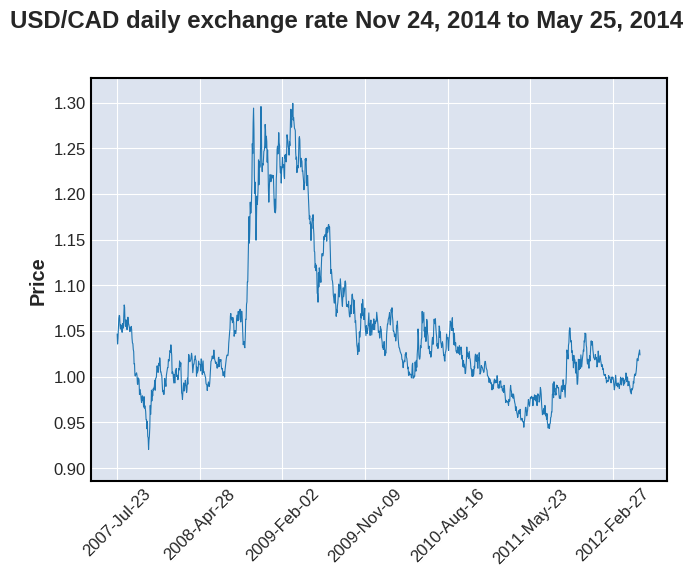

In [20]:
# visualize the data
mplfinance.plot(
    sample, 
    title='USD/CAD daily exchange rate Nov 24, 2014 to May 25, 2014',
    type='line'
);

A visual inspection shows that the data over the period in question does not appear to be stationary. Look to confirm this with an ADF test.

In [21]:
sample.head()

,open,high,low,close
date,,,,
2007-07-23,1.0482,1.0482,1.0424,1.0467
2007-07-24,1.0467,1.0472,1.0340,1.0357
2007-07-25,1.0356,1.0446,1.0339,1.0415
2007-07-26,1.0419,1.0553,1.0403,1.0534
2007-07-27,1.0541,1.0647,1.0525,1.0639


In [49]:
adf = adfuller(sample['close'])

In [50]:
adf

(-1.7318054098597013,
 0.4148043365073134,
 13,
 1252,
 {'1%': -3.4355838322867998,
  '5%': -2.863851267837805,
  '10%': -2.5680005460145554},
 -8283.701634296729)

From this test, we fail to reject the null that the time series is stationary.

### Hurst Exponent

**Calculating the Hurst Exponent of a Price Series**

Read [this](https://stackoverflow.com/questions/39488806/hurst-exponent-in-python) on stackoverflow to better understand the math.

**Interpreting the Hurst Exponent**

$$\langle |log(t + \tau) - log(t)|^2 \rangle \sim \tau^{2H}$$

We can interpret the hurst exponent, $H$ as follows:

- $H$ < 0.5 - The time series exhibits mean reversion  
- $H$ = 0.5 - The time series exhibits Geometric Brownian Motion  
- $H$ > 0.5 - The time series has a trend

In [54]:
compute_Hc(sample['close'], kind='price')

(0.529487177429452,
 1.182929545224964,
 [[10, 17, 31, 56, 100, 177, 316, 562, 1000, 1266],
  [4.135265422294437,
   5.44982302860246,
   6.920891509581118,
   9.777253974323402,
   14.359298516647344,
   18.09139969202426,
   22.2967039305738,
   33.412514803926214,
   49.797981788345815,
   52.307189900764996]])

With a Hurst exponent of 0.5295, this series appears very likely to be a 'random walk'

**Variance Ratio Test**

NEED DOCUMENTATION HERE

In [55]:
VarianceRatio(sample['close'])

Test Statistic,-0.355
P-value,0.723
Lags,2


### Cointegration

**Definition:** need definition here

Cointegration Tests

### Johanssen Test